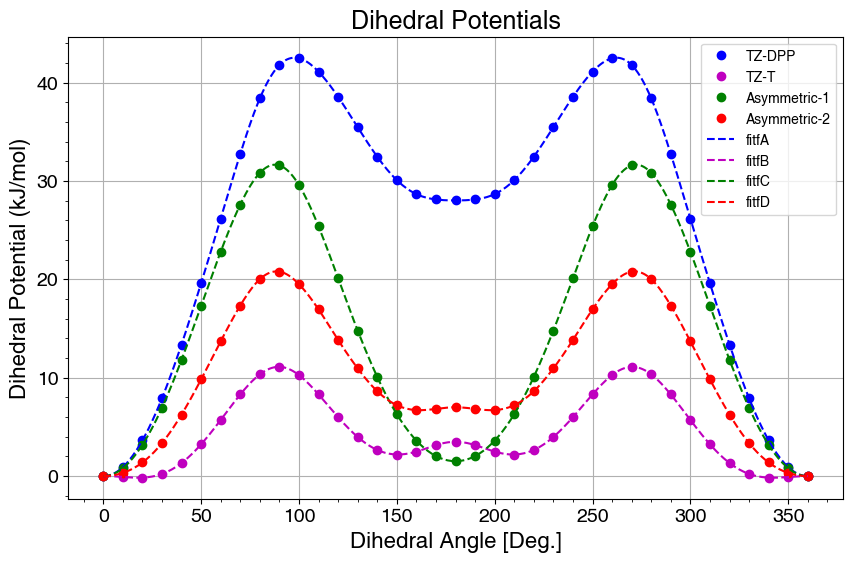

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, cumulative_trapezoid
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import scipy.constants as sc
import random

temperature = 420  # K
kTval = sc.R * temperature / 1000  # kJ/mol
n_repeat_units = 20
prob = 1
n_samples = 50000
# Molecular chain parameters
# The angle order has been changed, which is different from the original logic.
# Labeling starts from the 0th angle. The angle between the [0, 1] bond and the [1, 2] bond is angle[1].
# This makes it more accurate when connecting to the previous unit.
# Rotation label, corresponding to the current bond. 0 means no rotation, 1 means dihedral 1, 2 means dihedral 2, etc.
l1 = [2.462, 1.437, 3.509, 1.437, 2.462, 1.439, 2.522,1.430,1.371,1.456,2.526,1.439]
Angle1 = np.deg2rad(np.array([11.54, 13.09, 29.07, -29.07, -13.09, -11.54, 14.97,9.52,48.88,-55.89,-13.40,-15.03]))
rotaion1 = [0, 1, 0, 1, 0, 2, 0, 3, 0, 4, 0, 2]
l2 = [2.462, 1.437, 3.509, 1.437, 2.462, 1.439, 2.526,1.456,1.371,1.430,2.522,1.439]
Angle2 = np.deg2rad(np.array([11.54, 13.09, 29.07, -29.07, -13.09, -11.54, 15.03, 13.40, 55.89,-48.88,-9.52,-14.97]))
rotaion2 = [0, 1, 0, 1, 0, 2, 0, 4, 0, 3, 0, 2]

def read_data(file_name):
    data = np.loadtxt(file_name)
    data = np.reshape(data, (-1, 2))
    mirrored = np.column_stack((-data[:, 0] + 360, data[:, 1]))
    combined = np.vstack((data, mirrored))
    combined = np.unique(combined, axis=0)
    return combined[np.argsort(combined[:, 0])]


label_a = 'TZ-DPP'
label_b = 'TZ-T'
label_c = 'Asymmetric-1'
label_d = 'Asymmetric-2'
a = read_data(f"{label_a}.txt")
b = read_data(f"{label_b}.txt")
c = read_data(f"{label_c}.txt")
d = read_data(f"{label_d}.txt")
fitfa = interp1d(a[:, 0], a[:, 1], kind='cubic', fill_value="extrapolate")
fitfb = interp1d(b[:, 0], b[:, 1], kind='cubic', fill_value="extrapolate")
fitfc = interp1d(c[:, 0], c[:, 1], kind='cubic', fill_value="extrapolate")
fitfd = interp1d(d[:, 0], d[:, 1], kind='cubic', fill_value="extrapolate")
# Plot the dihedral potentials
plt.figure(figsize=(10, 6))
plt.plot(a[:, 0], a[:, 1], 'bo', label=label_a)
plt.plot(b[:, 0], b[:, 1], 'mo', label=label_b)
plt.plot(c[:, 0], c[:, 1], 'go', label=label_c)
plt.plot(d[:, 0], d[:, 1], 'ro', label=label_d)
x_plot = np.linspace(0, 360, 361)
plt.plot(x_plot, fitfa(x_plot), 'b--', label='fitfA')
plt.plot(x_plot, fitfb(x_plot), 'm--', label='fitfB')
plt.plot(x_plot, fitfc(x_plot), 'g--', label='fitfC')
plt.plot(x_plot, fitfd(x_plot), 'r--', label='fitfD')
plt.xlabel("Dihedral Angle [Deg.]", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Dihedral Potential (kJ/mol)", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.minorticks_on()
plt.title("Dihedral Potentials", fontsize=18, fontfamily="Helvetica")
plt.show()

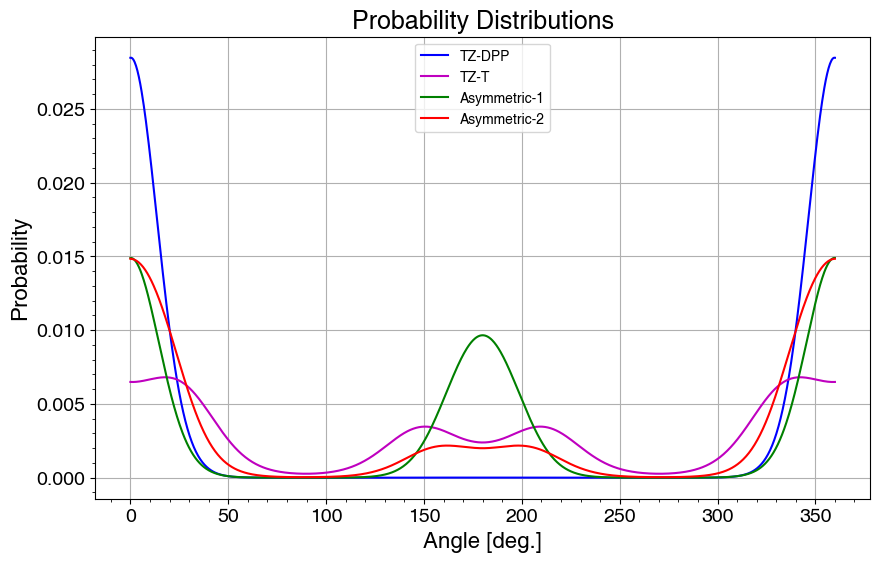

In [2]:
norm_val_a, _ = quad(lambda x: np.exp(-fitfa(x) / kTval), 0, 360)
norm_val_b, _ = quad(lambda x: np.exp(-fitfb(x) / kTval), 0, 360)
norm_val_c, _ = quad(lambda x: np.exp(-fitfc(x) / kTval), 0, 360)
norm_val_d, _ = quad(lambda x: np.exp(-fitfd(x) / kTval), 0, 360)
# Plot probability distributions
x_values = np.linspace(0, 360, 1000)
probA_vals = np.exp(-fitfa(x_values) / kTval) / norm_val_a
probB_vals = np.exp(-fitfb(x_values) / kTval) / norm_val_b
probC_vals = np.exp(-fitfc(x_values) / kTval) / norm_val_c
probD_vals = np.exp(-fitfd(x_values) / kTval) / norm_val_d

plt.figure(figsize=(10, 6))
plt.plot(x_values, probA_vals, 'b-', label=label_a)
plt.plot(x_values, probB_vals, 'm-', label=label_b)
plt.plot(x_values, probC_vals, 'g-', label=label_c)
plt.plot(x_values, probD_vals, 'r-', label=label_d)
plt.xlabel("Angle [deg.]", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Probability", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.title("Probability Distributions", fontsize=18, fontfamily="Helvetica")
plt.minorticks_on()
plt.show()

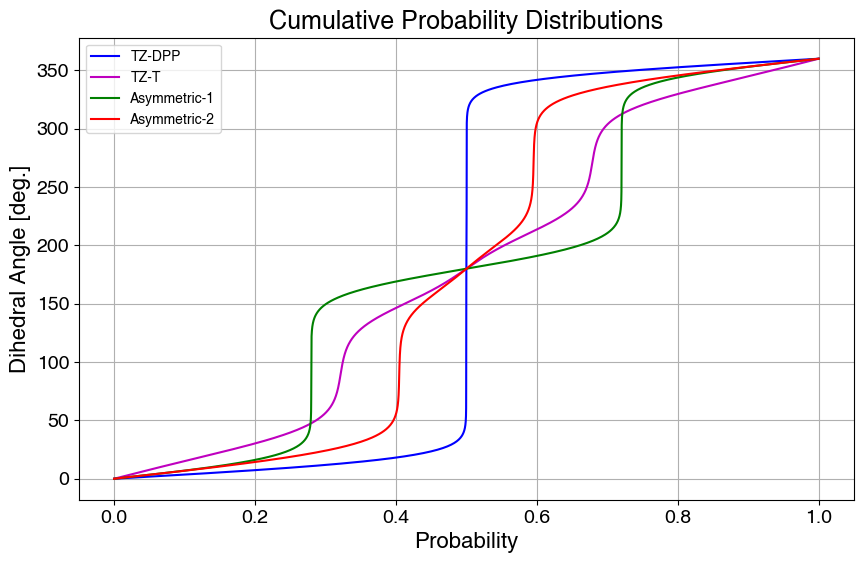

In [3]:
cum_a = cumulative_trapezoid(probA_vals, x_values, initial=0)
cum_b = cumulative_trapezoid(probB_vals, x_values, initial=0)
cum_c = cumulative_trapezoid(probC_vals, x_values, initial=0)
cum_d = cumulative_trapezoid(probD_vals, x_values, initial=0)
th_a = interp1d(cum_a/cum_a[-1], x_values, kind='cubic', fill_value="extrapolate")
th_b = interp1d(cum_b/cum_b[-1], x_values, kind='cubic', fill_value="extrapolate")
th_c = interp1d(cum_c/cum_c[-1], x_values, kind='cubic', fill_value="extrapolate")
th_d = interp1d(cum_d/cum_d[-1], x_values, kind='cubic', fill_value="extrapolate")
plt.figure(figsize=(10, 6))
plt.plot(cum_a/cum_a[-1], x_values, 'b-', label=label_a)
plt.plot(cum_b / cum_b[-1], x_values, 'm-', label=label_b)
plt.plot(cum_c / cum_c[-1], x_values, 'g-', label=label_c)
plt.plot(cum_d / cum_d[-1], x_values, 'r-', label=label_d)
plt.xlabel("Probability", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Dihedral Angle [deg.]", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.title("Cumulative Probability Distributions", fontsize=18, fontfamily="Helvetica")
plt.show()

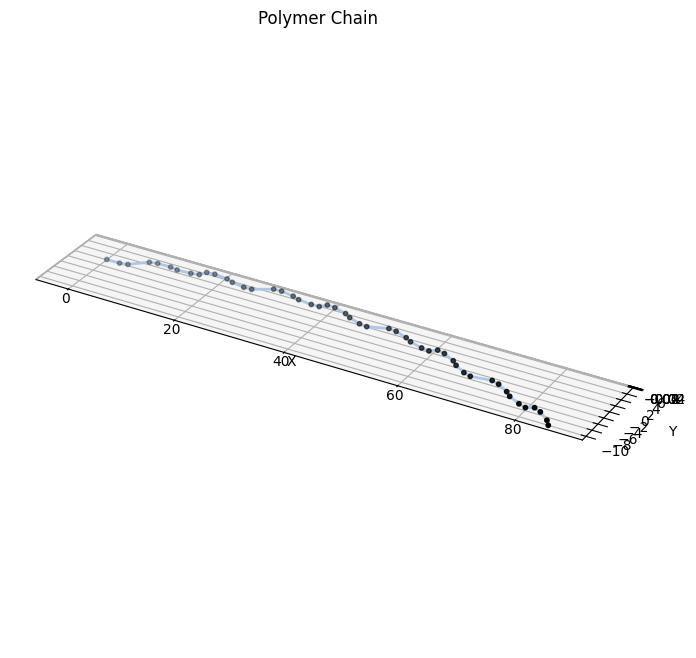

In [4]:
def choose_unit(probs, n):
    return np.random.choice([1, 2], size=n, p=probs)


def get_unit_params(unit_type):
    if unit_type == 1:
        return l1, Angle1, rotaion1
    else:
        return l2, Angle2, rotaion2


def rotation_matrix(axis, angle):
    axis = np.asarray(axis)
    axis = axis / np.linalg.norm(axis)
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def dihedralRotate(pts, nb, theta_deg):
    theta_rad = np.deg2rad(theta_deg)
    vec = pts[nb] - pts[nb - 1]
    vec_norm = np.linalg.norm(vec)
    axis = vec / vec_norm
    rot = rotation_matrix(axis, theta_rad)
    pts[nb + 1:] = (pts[nb + 1:] - pts[nb]) @ rot.T + pts[nb]
    return pts


def chain(n, prob1=0.1, rotate=False, cosVal=False):
    if cosVal:
        rotate = True
    unit_types = choose_unit([prob1, 1-prob1], n)
    all_params = [get_unit_params(ut) for ut in unit_types]
    all_l, all_Angle, all_rotation = zip(*all_params)
    unit_length = [len(l) for l in all_l]

    flat_l = np.concatenate(all_l)
    flat_Angle = np.concatenate(all_Angle)
    total_length = flat_l.shape[0]

    full_l_array = np.vstack((flat_l, np.zeros((2, total_length)))).T

    angles = np.cumsum(flat_Angle[np.arange(1, total_length)])
    vectors = full_l_array[np.arange(1, total_length)]  # shape (n-1, 3)

    cos_angles = np.cos(angles)
    sin_angles = np.sin(angles)
    rotated_x = vectors[:, 0] * cos_angles - vectors[:, 1] * sin_angles
    rotated_y = vectors[:, 0] * sin_angles + vectors[:, 1] * cos_angles
    rotated_z = vectors[:, 2]
    segments = np.column_stack((rotated_x, rotated_y, rotated_z))

    pts = np.cumsum(np.vstack((np.array([[0, 0, 0],
                                         full_l_array[0]]), segments)),
                    axis=0)
    if rotate:
        flat_rotation = np.concatenate([[0], *all_rotation])[:-1]
        for rot_type, th_func in [(1, th_a), (2, th_b), (3, th_c), (4, th_d)]:
            mask = flat_rotation == rot_type
            if np.any(mask):
                k_values = np.where(mask)[0]
                angles = th_func(np.random.rand(len(k_values)))
                for k, angle in zip(k_values, angles):
                    dihedralRotate(pts, k, angle)
    if cosVal:
        k_val = np.cumsum([0] + unit_length[:-1]) + 2
        vectors = pts[k_val] - pts[k_val-1]
        v0 = vectors[0]
        dots = np.einsum('ij,j->i', vectors, v0)  # Faster dot product
        norms = np.linalg.norm(vectors, axis=1) * np.linalg.norm(v0)
        return np.clip(dots/norms, -1, 1)
    else:
        return pts, unit_length, unit_types


def drawChain(pts, units, unit_types):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    pts_array = np.array(pts)
    ax.scatter(pts_array[:, 0],
               pts_array[:, 1],
               pts_array[:, 2],
               s=10,
               c='black')
    num_units = len(units)
    colormap = plt.get_cmap('tab20')
    current_index = 0
    for i, unit_length, unit_type in zip(range(num_units), units, unit_types):
        segment_points = pts_array[current_index:current_index + unit_length +
                                   1]
        ax.plot(segment_points[:, 0],
                segment_points[:, 1],
                segment_points[:, 2],
                color=colormap(unit_type),
                linewidth=2)
        current_index += unit_length

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    # ax.view_init(elev=90, azim=0)
    plt.title("Polymer Chain")
    plt.show()


drawChain(*chain(4, prob1=prob,rotate=False))

In [5]:
def calculate_cos_val():
    return chain(n_repeat_units, prob1=prob, rotate=True, cosVal=True)

import psutil
from joblib import Parallel, delayed
n_jobs = psutil.cpu_count(logical=False)
cosList2 = Parallel(n_jobs=n_jobs, verbose=1)(delayed(calculate_cos_val)() for _ in range(n_samples))
corr2 = np.mean(np.array(cosList2), axis=0)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 4616 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 12616 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done 23816 tasks      | elapsed:   38.7s
[Parallel(n_jobs=4)]: Done 38216 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 50000 out of 50000 | elapsed:  1.4min finished


slope: -0.23453178865366417
Correlation length: 4.263814324448409


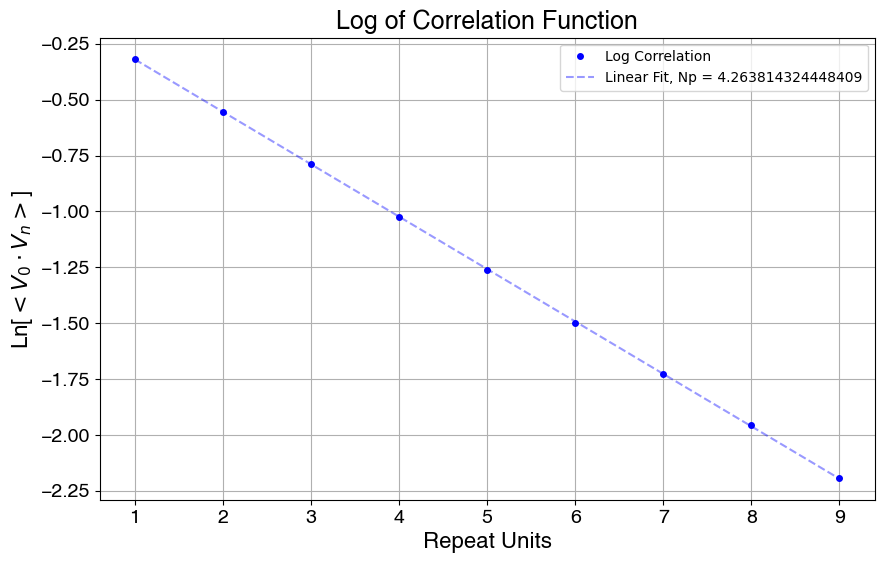

In [6]:
repeat_units = np.arange(len(corr2))
start_idx = 1
end_idx = 10
p = np.polynomial.polynomial.polyfit( repeat_units[start_idx:end_idx], np.log(corr2[start_idx:end_idx]), 1)
persistence_length = -1 / p[1]
print(f"slope: {p[1]}")
print(f"Correlation length: {persistence_length}")

plt.figure(figsize=(10, 6))
plt.plot(repeat_units[start_idx:end_idx],
         np.log(corr2[start_idx:end_idx]),
         'bo',
         markersize=4,
         label='Log Correlation')
plt.plot(repeat_units[start_idx:end_idx],
         np.polynomial.polynomial.polyval(repeat_units[start_idx:end_idx], p),
         'b--', alpha=0.4,
         label=f'Linear Fit, Np = {persistence_length}')
plt.xlabel("Repeat Units", fontsize=16, fontfamily="Helvetica")
plt.ylabel(r'Ln[$<V_0 \cdot V_n>$]',
           fontsize=16,
           fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.grid(True)
plt.legend()
plt.title("Log of Correlation Function", fontsize=18, fontfamily="Helvetica")
plt.show()